**SOW-MKI49: Neural Information Processing Systems**  
*Weeks 2 and 3: Assignment (200 points + 20 bonus points + 1 bonus point for each bug you find and another bonus point if you debug it and before you ask, no, typos unfortunately are not considered bugs - first come, first served)*  
Author: Umut

In [1]:
# Group number: 25
# Felicity Reddel, s4830717
# Max Reddel, s4830709
# Johan van den Heuvel, s4770528

In [3]:
import os

# os.chdir('/Users/Bayes/AnacondaProjects/NIPS/02_Computer_Vision/Assignment1')
os.getcwd()

'/Users/Bayes/AnacondaProjects/NIPS/02_Computer_Vision/NIPS2018/Assignment1'

In [4]:
batch_size = 4
data_directory = '/Users/Bayes/AnacondaProjects/NIPS/02_Computer_Vision'

#data_directory = 'Data'
#data_directory = r'/Users/DieGepardin/Documents/DATA' # Make a directory to store the data and enter it here.
                    # We will be using a smaller dataset (LFW) than the one used in the paper (CelebA) for computational resource considerations.
                    # Download it from http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz.
device = -1
epochs = 10
lambda_ = {'feature': 1., 'pixel': 1., 'total_variation': 1e-5}
model_directory = 'Model' # Make a directory to store the models and enter it here. Move Vgg4Layers.npz to the model directory.
outsize = (96, 96)

**Packages (10 points)**  
In this cell, you will import the required packages.  
*Tasks*   
- (1) It is always good practice to first think about the big picture and not rush into writing code before clearly knowing everything that you will have to do so as to avoid future complications. Therefore, your first task is to study the skeleton code and come up with a plan of how to proceed. (**0 points**)
- (2) However, I agree that doing so is arguably the most boring part of coding, and you rather skip it. To help you to resist the temptation of skipping going through the skeleton code, I have removed the import statements. Your second task is to Identify the required packages and import them. Note that if you are using Python 2.7, you should import print from the future. (**10 points**)

In [5]:
# (2) start
"""
In the lecture it was told we can use skicit-image for elementary image processing algorithms, e.g. resizing.
"""
import skimage
from skimage import io
from skimage.transform import resize

import matplotlib.pylab as plt
from IPython import display
import tarfile
import os
import cv2
import numpy as np

import chainer
from chainer import Link, Chain, ChainList, Function, iterators
import chainer.links as L 
import chainer.functions as F
from chainer.dataset import DatasetMixin, concat_examples
from chainer.serializers import load_npz, save_npz
from chainer.optimizers import Adam

from PIL import Image
from glob import glob

%matplotlib inline
# (2) end

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/chainer/_environment_check.py:38: UserWarning: Accelerate has been detected as a NumPy backend library.
vecLib, which is a part of Accelerate, is known not to work correctly with Chainer.
We recommend using other BLAS libraries such as OpenBLAS.
For details of the issue, please see
https://docs.chainer.org/en/stable/tips.html#mnist-example-does-not-converge-in-cpu-mode-on-mac-os-x.

Also note that Chainer does not officially support Mac OS X.
Please use it at your own risk.

  ''')  # NOQA


**Preprocessing functions (10 points + 5 bonus points)** (taken from https://github.com/mbeyeler/opencv-python-blueprints)  
In the following cell, you will implement some of the preprocessing functions. The rest of the preprocessing steps have already been applied to the data.  
*Tasks*
- (1) Implement the resizing operation. That is, you should extract the data, resize each portrait to 96 pixels x 96 pixels and save them to the data directory as JPG. (**10 points **)
- (2) The pencil sketch class implements the sketch effect in a simpler way than the one mentioned in the lecture. Explain how/why the used operations (blur and divide) convert portraits to sketches, and how it differs from that which was mentioned in the lecture? (**5 bonus points**)

### Extracting and resizing of only 700 images because of limited hardware capacities.

In [25]:
# (1) start
tar = tarfile.open(data_directory + "/" + "lfw-deepfunneled.tgz", "r")
tarNames = tar.getnames()
randList = np.random.choice(len(tarNames), 700, replace=False)
for index in randList:
    """
    Tarfile uses working directory, but skimage.io uses home directory. 
    So for skimage.io we need to append os.getcwd() i.e. the path to the working directory. 
    """
    filename = tarNames[index]
    tar.extract(filename, data_directory)
    imname = os.path.join(os.getcwd(), data_directory + "/" + filename) 
    im = io.imread(imname)
    im_resized = resize(im,outsize)
    io.imsave(imname, im_resized)    
print("done")
# (1) end

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


done


In [6]:
# (1) start
#tar = tarfile.open(data_directory + "/" + "lfw-deepfunneled.tgz", "r")
#for filename in tar.getnames():
#     """
#     Tarfile uses working directory, but skimage.io uses home directory. 
#     So for skimage.io we need to append os.getcwd() i.e. the path to the working directory. 
#     """
#    tar.extract(filename, data_directory)
#    imname = os.path.join(os.getcwd(), data_directory + "/" + filename) 
#    im = io.imread(imname)
#    im_resized = resize(im,outsize)
#    io.imsave(imname, im_resized)    
#print("done")
# (1) end

class PencilSketch:
    """Pencil sketch effect
        A class that applies a pencil sketch effect to an image.
    """

    def __init__(self, dimension):
        """Initialize parameters
            :param (width, height): Image size.
        """
        self.width, self.height = dimension
        

        # try to open background canvas (if it exists)
        #self.canvas = cv2.imread(bg_gray, cv2.CV_8UC1)
        #if self.canvas is not None:
        #    self.canvas = cv2.resize(self.canvas, (self.width, self.height))

    def render(self, img_rgb):
        """Applies pencil sketch effect to an RGB image
            :param img_rgb: RGB image to be processed
            :returns: Processed RGB image
        """
        img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
        img_blur = cv2.GaussianBlur(img_gray, (21, 21), 0, 0)
        img_blend = cv2.divide(img_gray, img_blur, scale=256)

        # return cv2.cvtColor(img_blend, cv2.COLOR_GRAY2RGB)
        return img_blend

def pencil_sketch(img_rgb):
    pencilSketch = PencilSketch((img_rgb.shape[1], img_rgb.shape[0]))

    return pencilSketch.render(img_rgb)

# (2) Write your answer here.
""" We are working with a greyed version of the original image and with a blurred version of the greyed image.
The blurred image is still very close to the greyed version. In brighter areas with less contrast, the dividing of
one version by the other results in (almost) totally white pixels. In darker areas with already a bit more contrast
(e.g. at borders and edges), the dividing operation does not change the image much. 
The extreme case: If totally black, it doesn't change at all.
The consequence is that we end up with a brighter and more contrast-full 'sketch'of the original color image.
So the small details go away because of the blur and the edges remain because of the contrast.

This seems a lot faster and easier to compute than edge detection (the method that was mentioned in the lecture).
Edge detection requires finding locations of abrupt changes in an image (e.g. brightness, depth, material structure).
This process often makes use of more extensive computations like first- & second-order derivations 
and non-linear differential equations. 
"""

def preprocess(img):
    if img.mode == 'L':
        return np.rollaxis(np.asarray(img, 'float32')[..., None], 2)
    else:
        return np.rollaxis(np.asarray(img, 'float32')[..., ::-1], 2)

**Data class**  
The following cell defines the data class. It is used to manage the data (loading, etc.). *You do not have to make any changes to the code.*  
*Task*
- (1) Study the code and refer to the chainer documentation if anything is unclear. You will be expected to write similar code by yourself in the coming practicals. (**0 points**)

In [7]:
class Dataset(DatasetMixin):
    def __init__(self, data_files):
        self.data_files = data_files

    def __len__(self):
        return len(self.data_files)

    def get_example(self, i):
        t = np.asarray(Image.open(self.data_files[i]).convert('RGB').resize((96, 96), Image.LANCZOS), 'f').transpose(2, 0, 1)
        x = pencil_sketch(np.asarray(Image.open(self.data_files[i]).convert('RGB').resize((96, 96), Image.LANCZOS), 'f'))[None]

        return t, x

**Model classes (45 points)**  
In the following cell you will implement the model classes.
*Tasks*   
- (1) Implement the layers of the model by filling in the missing code. (**20 points**)
- (2) Reimplement the model as a ChainList instead of a Chain. (**5 points**)
- (3) Implement the forward pass of the residual block by filling in the missing code. (**20 points**)

In [8]:
class Model(Chain):
    def __init__(self, in_channels, outsize):
        super(Model, self).__init__()

        with self.init_scope():
            # (1) start
            self.convolution2D_0 = L.Convolution2D(in_channels, 32, ksize=9, stride=1, pad=4) # potentially check None & in_channels
            self.batchNormalization_0 = L.BatchNormalization(32)
            self.convolution2D_1 = L.Convolution2D(None, 64, ksize=3, stride=2, pad=1)
            self.batchNormalization_1 = L.BatchNormalization(64)
            self.convolution2D_2 = L.Convolution2D(None, 128, ksize=3, stride=2, pad=1)
            self.batchNormalization_2 = L.BatchNormalization(128)
            self.residualBlock_3 = ResidualBlock(128, 128)
            self.residualBlock_4 = ResidualBlock(128, 128)
            self.residualBlock_5 = ResidualBlock(128, 128)
            self.residualBlock_6 = ResidualBlock(128, 128)
            self.residualBlock_7 = ResidualBlock(128, 128)
            self.deconvolution2D_8 = L.Deconvolution2D(None, 64, 3, 2, 1, nobias=True, outsize=outsize)
            self.batchNormalization_8 = L.BatchNormalization(64)
            # (1) end
            self.deconvolution2D_9 = L.Deconvolution2D(64, 32, 3, 2, 1, True, outsize) # self. needed!
            self.batchNormalization_9 = L.BatchNormalization(32) 
            self.convolution2D_10 = L.Convolution2D(32, 3, 9, pad = 4, nobias = True)
            self.batchNormalization_10 = L.BatchNormalization(3)

        self.in_channels = in_channels
        self.outsize = outsize

    def __call__(self, x, finetune = False):
        h = self.convolution2D_0(x)
        h = self.batchNormalization_0(h, finetune)
        h = F.relu(h)
        h = self.convolution2D_1(h)
        h = self.batchNormalization_1(h, finetune)
        h = F.relu(h)
        h = self.convolution2D_2(h)
        h = self.batchNormalization_2(h, finetune)
        h = F.relu(h)
        h = self.residualBlock_3(h, finetune)
        h = self.residualBlock_4(h, finetune)
        h = self.residualBlock_5(h, finetune)
        h = self.residualBlock_6(h, finetune)
        h = self.residualBlock_7(h, finetune)
        h = self.deconvolution2D_8(h)
        h = self.batchNormalization_8(h, finetune)
        h = F.relu(h)
        h = self.deconvolution2D_9(h)
        h = self.batchNormalization_9(h, finetune)
        h = F.relu(h)
        h = self.convolution2D_10(h)
        h = self.batchNormalization_10(h, finetune)
        y = 127.5 * F.tanh(h) + 127.5

        return y

class Model(ChainList):
    # (2) start
    def __init__(self, in_channels, outsize):
        super(Model, self).__init__()
        self.add_link(L.Convolution2D(in_channels, out_channels=32, ksize=9, stride=1, pad=4))
        self.add_link(L.BatchNormalization(size=32))
        
        self.add_link(L.Convolution2D(in_channels=32, out_channels=64, ksize=3, stride=2, pad=1))
        self.add_link(L.BatchNormalization(size=64))
        
        self.add_link(L.Convolution2D(in_channels=64, out_channels=128, ksize=3, stride=2, pad=1))
        self.add_link(L.BatchNormalization(size=128))
        
        self.add_link(ResidualBlock(in_channels=128, out_channels=128))
        self.add_link(ResidualBlock(in_channels=128, out_channels=128))
        self.add_link(ResidualBlock(in_channels=128, out_channels=128))
        self.add_link(ResidualBlock(in_channels=128, out_channels=128))
        self.add_link(ResidualBlock(in_channels=128, out_channels=128))
    
        self.add_link(L.Deconvolution2D(in_channels=128, out_channels=64, ksize=3, stride=2, pad=1, outsize=(48,48)))
        self.add_link(L.BatchNormalization(size=64))
    
        self.add_link(L.Deconvolution2D(64, 32, 3, 2, 1, True, outsize))
        self.add_link(L.BatchNormalization(32))
    
        self.add_link(L.Convolution2D(32, 3, 9, pad = 4, nobias = True))
        self.add_link(L.BatchNormalization(3))
    
        self.train = True
    
    def __call__(self, x):
        h = self[0](x)
        h = self[1](h)
        h = F.relu(h)
        
        h = self[2](h)
        h = self[3](h)
        h = F.relu(h)
        
        h = self[4](h)
        h = self[5](h)
        h = F.relu(h)
        
        h = self[6](h)
        h = self[7](h)
        h = self[8](h)
        h = self[9](h)
        h = self[10](h)
        
#         print(h.type)
        
        h = self[11](h)
        h = self[12](h)
        h = F.relu(h)
        
        h = self[13](h)
        h = self[14](h)
        h = F.relu(h)

        h = self[15](h)
        h = self[16](h)        
        y = 127.5 * F.tanh(h) + 127.5

        return y
    # (2) end

class ResidualBlock(Chain):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()

        with self.init_scope():
            self.batchNormalization_0 = L.BatchNormalization(size=out_channels)
            self.batchNormalization_1 = L.BatchNormalization(size=out_channels)
            self.convolution2D_0 = L.Convolution2D( in_channels, out_channels, 3, pad = 1, nobias = True)
            self.convolution2D_1 = L.Convolution2D(out_channels, out_channels, 3, pad = 1, nobias = True)

        self.in_channels = in_channels
        self.out_channels = out_channels

    def __call__(self, x, finetune = False):
        # (3) start
        h = self.convolution2D_0(x)
        h = self.batchNormalization_0(h)
        h = F.relu(h)
        h = self.convolution2D_1(h)
        h = self.batchNormalization_1(h)
        y = F.relu(h+x)
        # (3) start

        return y

**Loss classes (45 points)**  
In the following cell, you will implement the loss classes.  
*Tasks*  
- (1) You are provided with a custom VGG-16 implementation. How does it differ than the original implementation? Why can we get away with using the simpler implementation? (**5 points**)
- (2) Implement the missing convolution layer of the total variation loss by filling in the missing code. (**10 points**)
- (3) Implement the forward pass of the total variation loss by filling in the missing code. (**10 points**)
- (4) Implement the feature loss component in the forward pass of the loss function by filling in the missing code. (**10 points**)
- (5) Explain why the loss components are scaled. (**5 points**)
- (6) Explain why the target features are extracted in test mode. (**5 points**)

In [9]:
class Vgg4Layers(Chain):
    def __init__(self):
        super(Vgg4Layers, self).__init__()

        with self.init_scope():
            self.conv1_1 = L.Convolution2D(  3,  64, 3, pad = 1)
            self.conv1_2 = L.Convolution2D( 64,  64, 3, pad = 1)
            self.conv2_1 = L.Convolution2D( 64, 128, 3, pad = 1)
            self.conv2_2 = L.Convolution2D(128, 128, 3, pad = 1)

#         self.add_persistent('mean', np.array([[[[103.939]], [[116.779]], [[123.68]]]],'float32')) # hardcoded rgb mean

    def __call__(self, x):
        h = x - F.broadcast_to(self.mean, x.shape) # TODO: How is this subtracted if x is greyscale and subtract rgb means?
        h = self.conv1_1(h)
        h = F.relu(h)
        h = self.conv1_2(h)
        h = F.relu(h)
        h = F.max_pooling_2d(h, 2, 2)
        h = self.conv2_1(h)
        h = F.relu(h)
        h = self.conv2_2(h)
        y = F.relu(h)
        return y

class TotalVariationLoss(Chain):
    def __init__(self):
        super(TotalVariationLoss, self).__init__()

        with self.init_scope():
            self.convolution2D_0 = L.Convolution2D(3, 1, 2, nobias = True, initialW = np.array([3 * [[[-1], [1]]]], 'float32'))
            # (2) start
            self.convolution2D_1 = L.Convolution2D(3, 1, 2, nobias = True, initialW = np.array([3 * [[[-1, 1]]]], 'float32'))
            # (2) end   ##### TODO: CHECK WHETHER ROW VECTOR JUST ABOVE AND WHETHER GOOD LIKE THIS

    def __call__(self, x):
        # (3) start
        y = F.sqrt(F.sum(self.convolution2D_0(x)**2 + self.convolution2D_1(x)**2))
        # (3) end

        return y

class LossFunction(object):
    def __init__(self, lambda_):
        self.totalVariationLoss = TotalVariationLoss()
        self.vgg4Layers         = Vgg4Layers()

    def __call__(self, t, y):            
        with chainer.using_config('train', False):
            t_ = self.vgg4Layers(t)
            
        # (4) start        
        y_ = self.vgg4Layers(y)
        feature_loss = lambda_['feature'] * F.mean_squared_error(t_, y_)
        # (4) end
        pixel_loss = lambda_['pixel'] * F.mean_squared_error(t , y)
        total_variation_loss = lambda_['total_variation'] * self.totalVariationLoss(y)
        loss = feature_loss + pixel_loss + total_variation_loss
        return loss

# (1) Write your answer here.      ####### TODO: CHECK (1), (5), (6) 
"""It differs in the size/depth of the vgg network. The vgg16 is way deeper than the vgg4.
We can get away with the more shallow network because we only need rather simple features such as lines and edges,
which are encoded in rather more shallow layers. 
They need to be able to encode and recognize more complex features to classify complex objects correctly.
We are not in need of that as we don't need to identify complex features but only have the simple features."""
# (5) Write your answer here.
"""We scale the individual parts of the loss to shift the emphasis between them. It turns out that each of the 
parts is relevant. At the same time, a more fitting loss function can be achieved by adapting their relative weight
of the overall loss."""
# (6) Write your answer here.
"""We need the target features to be able to arrive at the feature_loss component. 
Without the features of the target images, we cannot judge how well the network is doing in this regard."""


'We need the target features to be able to arrive at the feature_loss component. \nWithout the features of the target images, we cannot judge how well the network is doing in this regard.'

**Initialization (10 points)**  
The following cell initializes the loss function, the loss history, the model, the optimizer, the datasets and the iterators. *You do not have to make any changes to the code.*  
*Tasks*
- (1) Study the code and refer to the chainer docuimentation if anything is unclear. You will be expected to write similar code by yourself in the coming practicals. (**0 points**)  
- (2) What are the boolean arguments that are passed to the SerialIterator class? (**5 points**)  
- (3) Why is it false for the training iterator but not for other iterators? In other words, what would happen if we were to set it to false for the training iterator and true for the other iterators? (**5 points**)

In [10]:
lossFunction = LossFunction(lambda_)
load_npz('{:s}/Vgg4Layers.npz'.format(model_directory), lossFunction.vgg4Layers)
lossFunction.vgg4Layers.add_persistent('mean', np.array([[[[103.939]], [[116.779]], [[123.68]]]],'float32')) # hardcoded rgb mean
loss_history = {'training': [], 'validation': []}
model = Model(1, outsize) if device < 0 else Model(1, outsize).to_gpu(device) # Specifying to which GPU
optimizer = Adam()

optimizer.setup(model)

data_file = sorted(glob('{}/lfw-deepfunneled/*/*.jpg'.format(data_directory)))
training_set = Dataset(data_file[:int(.64 * len(data_file))])                              # 64% for training
validation_set = Dataset(data_file[int(.64 * len(data_file)) : int(.8 * len(data_file))])  # 16% for validation
test_set = Dataset(data_file[:int(.8 * len(data_file))])                                  # 20% for testing
training_iterator = iterators.SerialIterator(training_set, batch_size, repeat=False, shuffle=True) # Shuffle because: more randomness during training? Using some examples multiple times -> generalizing better? 
test_iterator = iterators.SerialIterator(test_set, batch_size, repeat=False, shuffle=False)  # No shuffle to really test everything once? To have a stable evaluation metric
validation_iterator = iterators.SerialIterator(validation_set , batch_size, repeat=False, shuffle=False)# No shuffle to really test everything once? To have a stable evaluation metric


# (2) Write your answer here.
# repeat and shuffle
# (3) Write your answer here.
# Training iterator: Shuffle because: more randomness during training? Using some examples multiple times -> generalizing better? 
# Validation & Test iterators: No shuffle to really test everything once? To have a stable evaluation metric


**Training and validation (20 points)**  
In the following cell, you will train and validate your model.
*Tasks*   
- (1) Implement training loss estimation, backprop and parameter update. (**10 points**)
- (2) Implement validation loss history (**5 points**)
- (3) Implement model serialization  (**5 points**)

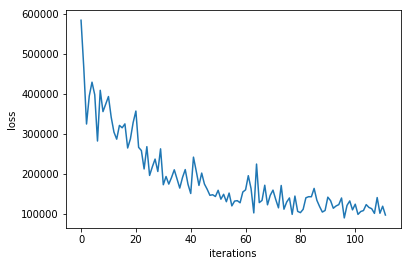

epoch:   1 / 010, training loss: 190411.3486, validation loss: 105062.6967.
epoch:   2 / 010, training loss: 0.0000, validation loss: 0.0000.
epoch:   3 / 010, training loss: 0.0000, validation loss: 0.0000.
epoch:   4 / 010, training loss: 0.0000, validation loss: 0.0000.
epoch:   5 / 010, training loss: 0.0000, validation loss: 0.0000.
epoch:   6 / 010, training loss: 0.0000, validation loss: 0.0000.
epoch:   7 / 010, training loss: 0.0000, validation loss: 0.0000.
epoch:   8 / 010, training loss: 0.0000, validation loss: 0.0000.
epoch:   9 / 010, training loss: 0.0000, validation loss: 0.0000.
epoch:  10 / 010, training loss: 0.0000, validation loss: 0.0000.


In [11]:
for epoch in range(epochs):
    loss_history['training'].append(0)
    
    #loss over 1 epoch
    arr = []

    for j, batch in enumerate(training_iterator):
        with chainer.using_config('train', True):
            t, x = concat_examples(batch, device) # TODO: Check forum again for answer by Umut, remove device param?
            y = model(x)
            # (1) start
            # loss estimation
            loss = lossFunction(t, y)
            
            # backprop
            model.cleargrads()
            loss.backward()
    
            # parameter update
            optimizer.update()
            # (1) end

        loss_history['training'][-1] += float(loss.data)
        arr.append(float(loss.data))
        
        display.display(plt.gcf())
        display.clear_output(wait=True)
        
        plt.plot(arr)
        plt.ylabel('loss')
        plt.xlabel('iterations')
        plt.show()
        
#         print(j, loss_history['training'][-1])

    loss_history['training'][-1] /= j + 1
    # (2) start
    loss_history['validation'].append(0)

    for j, batch in enumerate(validation_iterator):
        with chainer.using_config('train', False):
            t, x = concat_examples(batch, device)
            y = model(x)
            loss = lossFunction(t, y)

        loss_history['validation'][-1] += float(loss.data)

    loss_history['validation'][-1] /= j + 1
    # (2) end
    print('epoch: {:3d} / {:03d}, training loss: {:.4f}, validation loss: {:.4f}.'.format(epoch + 1, epochs, loss_history['training'][epoch], loss_history['validation'][epoch]))
    np.savez('{:s}/loss_history_{:03d}.npz'.format(model_directory, epoch), loss_history)
    # (3) start
    save_npz('{:s}/model_{:03d}.npz'.format(model_directory, epoch), model)
    # (3) end
    save_npz('{:s}/optimizer_{:03d}.npz'.format(model_directory, epoch), optimizer)

In [12]:
loss_history['training']

[190411.3486328125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

**Test (45 points + 15 bonus points)**  
In the following cell, you will test your model.  
*Tasks*
- (1) Estimate the test loss, print it and save it. (**15 points**)
- (2) Estimate the validation metrics, print them and save them (tip: scikit-image) (**15 bonus points**)
- (3) Plot example results (i.e., plot a few t, x and y) (**10 points**)
- (4) Dicuss your implementation in 300 - 350 words (e.g., how good your results are, how you can improve your model, etc.) (**20 points**)

In [ ]:
# (1), (2) and (3) start
# .
# .
# .
# (1), (2) and (3) end

# (4) Write your answer here.